# Classification of road accident severity using Machine Learning techniques

## Setting up the environment

### Import libraries and load data

In [1]:
import pandas as pd  
import numpy as np
import h2o
import matplotlib.pyplot as plt
import random

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from matplotlib.colors import ListedColormap
from sklearn import svm, grid_search, neighbors, datasets, preprocessing, metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV


# Load the CSV file into a Pandas Dataframe - NOTE: Change the directory to where your data is stored
originalData = pd.read_csv(r'DATA LOCATION'),low_memory=False )

# Look at the dimensions of the data, and the features datatypes
print(originalData.shape)
print(originalData.dtypes)

C:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


(464697, 33)
Accident_Index                                  object
Location_Easting_OSGR                            int64
Location_Northing_OSGR                           int64
Longitude                                      float64
Latitude                                       float64
Police_Force                                     int64
Accident_Severity                                int64
Number_of_Vehicles                               int64
Number_of_Casualties                             int64
Date                                            object
Day_of_Week                                      int64
Time                                            object
Local_Authority_(District)                       int64
Local_Authority_(Highway)                       object
1st_Road_Class                                   int64
1st_Road_Number                                  int64
Road_Type                                       object
Speed_limit                                      int

## Data Exploration & Pre-Processing

Exploring a subset of the data to get a feel for it, and to try to understand the features within. This will help us to identify what pre-processing techniques we will need to apply, in order to better prepare our data

In [2]:
originalData.head()

,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,...,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,LSOA_of_Accident_Location,Year
0,201201BS70001,527200,178760,-0.169101,51.493429,1,3,2,1,19/01/2012,...,Pedestrian phase at traffic signal junction,Darkness: Street lights present and lit,Fine without high winds,Dry,None,None,1,Yes,E01002821,2012
1,201201BS70002,524930,181430,-0.200838,51.517931,1,3,2,1,04/01/2012,...,No physical crossing within 50 meters,Darkness: Street lights present and lit,Fine without high winds,Dry,None,None,1,Yes,E01004760,2012
2,201201BS70003,525860,178080,-0.188636,51.487618,1,3,2,1,10/01/2012,...,non-junction pedestrian crossing,Daylight: Street light present,Fine without high winds,Dry,None,None,1,Yes,E01002893,2012
3,201201BS70004,524980,181030,-0.200259,51.514325,1,3,1,1,18/01/2012,...,No physical crossing within 50 meters,Daylight: Street light present,Fine without high winds,Dry,None,None,1,Yes,E01002886,2012
4,201201BS70005,526170,179200,-0.183773,51.497614,1,3,1,1,17/01/2012,...,No physical crossing within 50 meters,Darkness: Street lights present and lit,Fine without high winds,Dry,None,None,1,Yes,E01002890,2012


### Removing duplicate features and reducing dimensionality

Reducing the number of dimensions of the data by taking a look at each of the columns individually and removing those that are either duplicates (identical features represented in different measures) or those that we feel have little to no predictive power for the models that will be built.

- The feature 'Junction_Detail' has no value stored for every example in our dataset. Therefore we can remove this column, as it will have no impact on our model

In [3]:
originalData['Junction_Detail'].value_counts()

Series([], Name: Junction_Detail, dtype: int64)

In [4]:
originalData = originalData.drop(['Junction_Detail'], axis=1)

- The features 'Location_Easting_OSGR' and 'Location_Northing_OSGR' are an alternative way of specifying the location of an accident to the 'Longitude' and 'Latitude'. As these columns are essentially a duplication of data, we can choose to remove one set of features. We have decided to remove'Location_Easting_OSGR' and 'Location_Northing_OSGR'.

In [5]:
originalData = originalData.drop(['Location_Easting_OSGR'], axis=1)
originalData = originalData.drop(['Location_Northing_OSGR'], axis=1)

- The 'Police_Force' feature indicates the police force that had been assigned to the accident (usually the closest police force to the accident location). We already have a measure for location in the data set; furthermore, it is likely that this feature will have little to not prediction power. With that being said, we have chosen to remove this column from our dataset.

In [6]:
originalData = originalData.drop(['Police_Force'], axis=1)

- 'Accident_Index' contains the unique identifier for each example in this dataset, which can be very useful if we wanted to locate specific records of accidents that ocurred. However, in turns of predictive power, since each example in the dataset will have a unique 'Accident_Index' value, the feature will not contribute anything to our model. Therefore it can be removed from the dataset.

In [7]:
originalData = originalData.drop(['Accident_Index'], axis=1)

- 'Local_Authority_Highway' and 'Local_Authority_District' represents the identities of the authorities that are situated nearest to the location of the accident. Much like the 'Police_Force' feature, these features are unlikely to have a substantial input to our model, and so they can be removed from the dataset.

In [8]:
originalData = originalData.drop(['Local_Authority_(District)'], axis=1)
originalData = originalData.drop(['Local_Authority_(Highway)'], axis=1)

- We also decided to remove the 'Date' column as we felt that this feature would not contribute too much to our model. If we had more time to complete this project, we could have looked at converting the 'Date' column to a 'Season' column. This could help us look at any potential relationships between the quantity and/or severity of accidents and the season that they occur. (For example; Winter could potentially have a higher quantity of severe accidents due to icy roads, poor vision, and snow)

In [9]:
originalData = originalData.drop(['Date'], axis=1)

- There are several features that help describe the roads our accidents happen on. The 'road class' lists the type of road the accident happens on (single carriage way, motorway, junction, etc) which can potentially influence our model. '1st Road Number' identifies the specific road that the accident has happened on (M40, A1427, M6, etc). Furthermore, if the accident happened on a junction, then '2nd Road Number' will identify the name of the other road. For this project, we will ignore the specific road names and just work with the road class. If we had more time to complete this project, then we could dive deeper into the location of the accidents by mapping them all out. We could then use clustering to identify areas where accidents are more frequent and try to understand 'why' that is the case.

In [10]:
originalData = originalData.drop(['1st_Road_Number'], axis=1)
originalData = originalData.drop(['2nd_Road_Number'], axis=1)

- It is also unlikely that the presence or absence of a Police officer at the accident scene will add much predictive value to our model. Therefore, we have chosen to omit this column from our dataset

In [11]:
originalData = originalData.drop(['Did_Police_Officer_Attend_Scene_of_Accident'], axis=1)

- Finally, the 'LSOA_of_Accident_Location' translates to the 'Lower Layer Super Output Area' and is another measure of geographic area/location. As previosuly stated, we are using the Latitude and Longitude columns for our study, and so we can remove this feature.

In [12]:
originalData = originalData.drop(['LSOA_of_Accident_Location'], axis=1)

We are now left with the following set of features:

In [13]:
print(originalData.dtypes)

Longitude                                  float64
Latitude                                   float64
Accident_Severity                            int64
Number_of_Vehicles                           int64
Number_of_Casualties                         int64
Day_of_Week                                  int64
Time                                        object
1st_Road_Class                               int64
Road_Type                                   object
Speed_limit                                  int64
Junction_Control                            object
2nd_Road_Class                               int64
Pedestrian_Crossing-Human_Control           object
Pedestrian_Crossing-Physical_Facilities     object
Light_Conditions                            object
Weather_Conditions                          object
Road_Surface_Conditions                     object
Special_Conditions_at_Site                  object
Carriageway_Hazards                         object
Urban_or_Rural_Area            

In [14]:
originalData.head()

,Longitude,Latitude,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Day_of_Week,Time,1st_Road_Class,Road_Type,Speed_limit,...,2nd_Road_Class,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Year
0,-0.169101,51.493429,3,2,1,5,20:35,3,Single carriageway,30,...,5,None within 50 metres,Pedestrian phase at traffic signal junction,Darkness: Street lights present and lit,Fine without high winds,Dry,None,None,1,2012
1,-0.200838,51.517931,3,2,1,4,17:00,4,Single carriageway,30,...,6,None within 50 metres,No physical crossing within 50 meters,Darkness: Street lights present and lit,Fine without high winds,Dry,None,None,1,2012
2,-0.188636,51.487618,3,2,1,3,10:07,3,One way street,30,...,6,None within 50 metres,non-junction pedestrian crossing,Daylight: Street light present,Fine without high winds,Dry,None,None,1,2012
3,-0.200259,51.514325,3,1,1,4,12:20,5,Single carriageway,30,...,6,None within 50 metres,No physical crossing within 50 meters,Daylight: Street light present,Fine without high winds,Dry,None,None,1,2012
4,-0.183773,51.497614,3,1,1,3,20:24,4,Single carriageway,30,...,6,None within 50 metres,No physical crossing within 50 meters,Darkness: Street lights present and lit,Fine without high winds,Dry,None,None,1,2012


### Resolve examples containing NULL values 

In [15]:
# If no Time value stored, value is 'None'
originalData['Time'].fillna('None', inplace=True)

# If no Junction Control value stored, value is UNK (unknown)
originalData['Junction_Control'].fillna('UNK', inplace=True)

# If no Road Surface Conditions value stored, assume normal road condition
originalData['Road_Surface_Conditions'].fillna('Normal', inplace=True)

# If no Special Conditions at Site value stored, assume no special conditions
originalData['Special_Conditions_at_Site'].fillna('None', inplace=True)

# If no Carriageway Hazards value stored, assume no hazard present
originalData['Carriageway_Hazards'].fillna('None', inplace=True)

The 'Time' feature details what time of day the accident happens. This could have a strong influence on the behaviour of the model as accidents could be more likely to occur at certain periods of the day (at night, early morning, during rush hours). Some of our examples do not have a time recorded against them. The most likely way we could capture/infer these values would be to search the internet for news reports on these accidents; however, this would be a time-consuming process and some of the minor accidents may not have been reported! With that being said, we have decided to take the simple route for this project by deleting examples from our dataset that do not have a time recorded against them.

In [16]:
# OriginalData = all istances where time is not 'None'
originalData = originalData[originalData['Time'] != 'None']

### Altering column values and datatypes

In [17]:
# Mapping values
originalData['Urban_or_Rural_Area'] = originalData['Urban_or_Rural_Area'].map({1: 'Urban', 2: 'Rural'})
originalData['Day_of_Week'] = originalData['Day_of_Week'].map({1: 'Monday', 2: 'Tuesday', 3: 'Wedesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday', 7: 'Sunday'})

# Altering feature datatypes
originalData['Junction_Control'] = originalData['Junction_Control'].astype(str)
originalData['Road_Surface_Conditions'] = originalData['Road_Surface_Conditions'].astype(str)
originalData['Special_Conditions_at_Site'] = originalData['Special_Conditions_at_Site'].astype(str)
originalData['Carriageway_Hazards'] = originalData['Carriageway_Hazards'].astype(str)


# Splitting Time into hours and minutes and then dropping the original time column
originalData[['Hour', 'Minutes']] = originalData['Time'].astype(str).str.split(':', expand=True)
originalData = originalData.drop(['Time'], axis=1)

### Rearranging the data frame

In [18]:
# Move class target variable to the end of the table
cols = list(originalData)
cols.insert(33, cols.pop(cols.index('Accident_Severity')))
originalData = originalData.loc[:, cols]

### Outlier detection

In [19]:
# look at frequencies for each column
for column in originalData:
    print(originalData[column].value_counts())

-0.104426    32
-0.120956    19
-0.163926    17
-0.217197    17
-0.085209    16
-0.066819    16
-0.069625    16
-2.066352    15
-0.160834    14
-0.150613    14
-0.096015    14
 0.054915    14
-0.172764    13
-1.841695    13
-0.319581    13
-0.056477    13
-4.063979    13
-0.052266    13
-0.089038    13
-0.099368    12
-0.404123    12
-0.170692    12
-0.013343    12
-0.173445    12
-1.901048    12
-0.129863    12
-0.159763    12
-0.056478    12
-0.318182    12
-0.036278    11
             ..
-0.079291     1
-1.241491     1
-0.288260     1
-3.648327     1
-2.135550     1
-3.789911     1
-0.772257     1
-1.598884     1
 0.772969     1
-2.184066     1
-1.515444     1
-2.177619     1
-0.391629     1
-2.091539     1
 0.051640     1
-2.894137     1
-0.797226     1
-5.222742     1
 0.417971     1
-1.349229     1
-1.690446     1
-0.894946     1
-1.557174     1
-0.843067     1
-1.074777     1
 0.179048     1
-2.748432     1
-2.360752     1
 0.272029     1
-1.628682     1
Name: Longitude, Length:

- In the 'Number_of_Vehicles' column, the range of values tend to lie between 1 and 20. In fact, 464,682 out of 464,684 (99.99957%) of the values lie within this range. There is a frequency count of 1 for 67 vehicles which is significantly higher than expected. After searching for a record of this accident online, we can confirm that such accident DID happen, and so we will keep this record in the data.


In [20]:
originalData.loc[originalData['Number_of_Vehicles'] == 67]

,Longitude,Latitude,Number_of_Vehicles,Number_of_Casualties,Day_of_Week,1st_Road_Class,Road_Type,Speed_limit,Junction_Control,2nd_Road_Class,...,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Year,Hour,Minutes,Accident_Severity
287670,0.749417,51.39166,67,70,Friday,3,Dual carriageway,70,UNK,-1,...,Daylight: Street light present,Fog or mist,Dry,None,None,Rural,2013,07,15,2



- Likewise, looking at the number of casualties, we have a frequecy of 1 for values '93' and '87'. Again, these numbers are quite high and so we checked online to see if they were accurate recordings.

In [21]:
originalData.loc[originalData['Number_of_Casualties'] == 93]

,Longitude,Latitude,Number_of_Vehicles,Number_of_Casualties,Day_of_Week,1st_Road_Class,Road_Type,Speed_limit,Junction_Control,2nd_Road_Class,...,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Year,Hour,Minutes,Accident_Severity
410419,-0.222211,51.683269,2,93,Tuesday,3,Single carriageway,60,UNK,-1,...,Daylight: Street light present,Fine without high winds,Dry,None,None,Rural,2014,08,22,2


In [22]:
originalData.loc[originalData['Number_of_Casualties'] == 87]

,Longitude,Latitude,Number_of_Vehicles,Number_of_Casualties,Day_of_Week,1st_Road_Class,Road_Type,Speed_limit,Junction_Control,2nd_Road_Class,...,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Year,Hour,Minutes,Accident_Severity
362889,-1.718034,54.863663,2,87,Wedesday,5,Single carriageway,30,Giveway or uncontrolled,3,...,Daylight: Street light present,Fine without high winds,Dry,None,None,Rural,2014,08,22,2


- According to the speed-limit data, only one accident occurred where the speed limit was 10MPH. It is very likely that more accidents at this speed limit have happened during the observed years but have not been reported due to the lack of scale and severity of the accident.

In [23]:
print(originalData['Speed_limit'].value_counts())

30    304836
60     64458
40     37538
70     31484
50     17312
20      9055
10         1
Name: Speed_limit, dtype: int64


### Looking at the natural data split per class

In [24]:
# Split data according to Accident Severity
severity1 = originalData.loc[originalData['Accident_Severity'] == 1]
severity2 = originalData.loc[originalData['Accident_Severity'] == 2]
severity3 = originalData.loc[originalData['Accident_Severity'] == 3]


# Count instances of each dataframe
print('Severity 1 (fatal) has shape:' + ' ' + str(severity1.shape))
print('Severity 2 (serious) has shape:' + ' ' + str(severity2.shape))
print('Severity 3 (slight) has shape:' + ' ' + str(severity3.shape))

Severity 1 (fatal) has shape: (5302, 22)
Severity 2 (serious) has shape: (66778, 22)
Severity 3 (slight) has shape: (392604, 22)


Class imbalance is evident in this dataset. Class 1 has 5,302 example, whereas Class 3 has 392,604 - over 74 times the amount! Class imbalance can adversely affect the performance of Machine Learning models by introducing bias and creating a model that will generalise better to the majority class. For example, if we just had Class 1 and Class 3 in our study, then the ML algorithm could predict every training example to be in Class 3 and would be right for 392,604 out of 397,906 examples. This would yield a model accuracy of 98.66% but would only accommodate for one class. Every instance it recieves that is of Class 1, it would get wrong.  

### Under- and Over-sampling

In [25]:
# Random sample 40,000 instances using under-sampling
severity2 = severity2.sample(n=40000)
severity3 = severity3.sample(n=40000)

# Random sample 40,000 instances using over-sampling with replacement
severity1 = severity1.sample(n=40000, replace=True)


# Count instances of each dataframe
print('Severity 1 has shape:' + ' ' + str(severity1.shape))
print('Severity 2 now has shape:' + ' ' + str(severity2.shape))
print('Severity 3 now has shape:' + ' ' + str(severity3.shape))

Severity 1 has shape: (40000, 22)
Severity 2 now has shape: (40000, 22)
Severity 3 now has shape: (40000, 22)


### Creating a new dataframe with an equal number of examples per class

In [26]:
#Concatenating the data into a new frame
newdata = pd.concat([severity1, severity2, severity3])
print('newdata has shape:' + ' ' + str(newdata.shape))

newdata has shape: (120000, 22)


###  One Hot Encode Categorical columns

In [27]:
#Convert categorical variables into dummy/indicator variables
newdata = pd.get_dummies(newdata)
print(newdata.head())

        Longitude   Latitude  Number_of_Vehicles  Number_of_Casualties  \
231455  -0.276876  53.657062                   2                     3   
77242   -1.396922  54.843432                   2                     5   
263935  -0.056264  51.946635                   1                     2   
114813  -0.651327  52.407753                   2                     3   
457125  -2.026546  57.526138                   1                     5   

        1st_Road_Class  Speed_limit  2nd_Road_Class  Year  Accident_Severity  \
231455               6           40               6  2013                  1   
77242                4           60              -1  2012                  1   
263935               3           60              -1  2013                  1   
114813               5           60              -1  2012                  1   
457125               3           60              -1  2014                  1   

        Day_of_Week_Friday     ...      Minutes_50  Minutes_51  Minutes_52

### Splitting dataset into train and test subsets

In [29]:
# X is all the features, y is the target variable
X = np.array(newdata.loc[:, newdata.columns != 'Accident_Severity'])
y = np.array(newdata.loc[:, newdata.columns == 'Accident_Severity'])

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print("Number instances X_train dataset: ", X_train.shape)
print("Number instances y_train dataset: ", y_train.shape)
print("Number instances X_test dataset: ", X_test.shape)
print("Number instances y_test dataset: ", y_test.shape)

Number instances X_train dataset:  (96000, 156)
Number instances y_train dataset:  (96000, 1)
Number instances X_test dataset:  (24000, 156)
Number instances y_test dataset:  (24000, 1)


## Experiment Conduction

### Random Forest 

The SciKit Random Forest Classifier algorithm only takes inputs of the integer datatype. Some of our labels are categorical and so One Hot Encoding has been applied to convert these into numerical data using a one-of-K scheme. 

For 20 trees, accuracy: 82.9166666667
For 50 trees, accuracy: 84.1166666667
For 100 trees, accuracy: 84.4083333333
For 150 trees, accuracy: 84.4625
For 200 trees, accuracy: 84.4458333333
For 220 trees, accuracy: 84.4666666667
For 230 trees, accuracy: 84.3916666667
For 250 trees, accuracy: 84.4041666667
For 300 trees, accuracy: 84.4541666667
Final Result
[[8011   12    5]
 [ 159 5431 2380]
 [  27 1148 6827]]
             precision    recall  f1-score   support

          1       0.98      1.00      0.99      8028
          2       0.82      0.68      0.75      7970
          3       0.74      0.85      0.79      8002

avg / total       0.85      0.84      0.84     24000



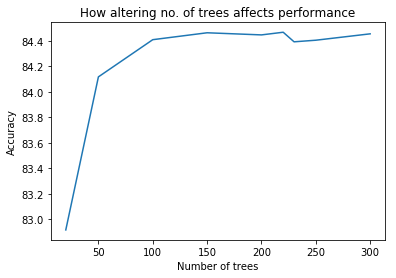

In [40]:
# Values to be plot on our graph
graphx = [20,50,100,150,200,220,230,250,300] #The number of trees to be made
graphy = []

# Run the algorithm with 'i' trees, and calculate predictions
for i in graphx:
    fit1=RandomForestClassifier(n_estimators=i)
    fit1.fit(X_train,y_train.ravel())
    y_pred=fit1.predict(X_test)

    
    # print evaluation metrics
    graphy.append(metrics.accuracy_score(y_test, y_pred))
    print("For" + " " + str(i) + " " + "trees, accuracy:",100*metrics.accuracy_score(y_test, y_pred))
    if i == 300:
        print("Final Result")
        print(confusion_matrix(y_test, y_pred, labels=[1, 2, 3]))
        print(metrics.classification_report(y_test, y_pred))

# change to a percentage        
graphy = [i * 100 for i in graphy]

# Create and plot graph
plt.plot(graphx, graphy)
plt.title('How altering no. of trees affects performance')
plt.xlabel('Number of trees')
plt.ylabel('Accuracy')
plt.show()

## K-Nearest Neighbours

For K-Nearest Neighbours, we have used the SciKit package's implementation. This takes in a value for 'n_neighbors' which is our choice of 'k' for the number of neighbors the algorithm will compare the data point to. We are testing the algorithm with the K values - 3, 5, 10, 15, 20, 30, 50. We have set the parameter for the 'algorithm' to auto - this chooses the most suitable algorithm based on the number of dimensions in our data.

[[7965   49   14]
 [1286 4380 2304]
 [ 384 2108 5510]]
             precision    recall  f1-score   support

          1       0.83      0.99      0.90      8028
          2       0.67      0.55      0.60      7970
          3       0.70      0.69      0.70      8002

avg / total       0.73      0.74      0.73     24000

For 3 Nearest Neighbours, accuracy: 0.743958333333
For 5 Nearest Neighbours, accuracy: 0.72925
For 10 Nearest Neighbours, accuracy: 0.690708333333
For 15 Nearest Neighbours, accuracy: 0.675416666667
For 20 Nearest Neighbours, accuracy: 0.671791666667
For 30 Nearest Neighbours, accuracy: 0.664208333333
For 50 Nearest Neighbours, accuracy: 0.655


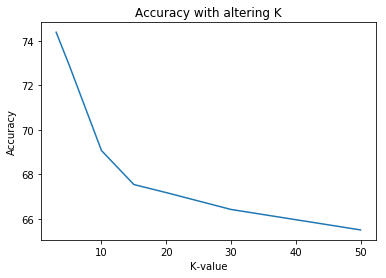

In [41]:
# Values to be plot on our graph
graphx = [3,5,10,15,20,30,50] #values of K
graphy = []


for i in graphx:
    #Create KNN Classifier
    knn = KNeighborsClassifier(n_neighbors=i, algorithm = 'auto')
    
    #Train the model using the training sets
    knn.fit(X_train,y_train.ravel())
    
    #Predict the response for test dataset
    y_pred = knn.predict(X_test)

    # print evaluation metrics
    if i == 3:
        print(confusion_matrix(y_test, y_pred, labels=[1, 2, 3]))
        print(metrics.classification_report(y_test, y_pred))
   
    graphy.append(metrics.accuracy_score(y_test, y_pred))
    print("For" + " " + str(i) + " " + "Nearest Neighbours, accuracy:",metrics.accuracy_score(y_test, y_pred))
        
# change to a percentage         
graphy = [i * 100 for i in graphy]

# Create and plot graph
plt.plot(graphx, graphy)
plt.title('Accuracy with altering K')
plt.xlabel('K-value')
plt.ylabel('Accuracy')
plt.show()

## Support Vector Machine

For Support Vector Machine, we have used the SciKit package's implementation. This takes in a value for 'kernal' - The main function of this is to transform the dataset input into the required form, the default is set to linear. It also takes in a value for the parameter 'C' - the Penalty parameter C of the error term and parameter 'gamma' - the kernal coefficient for the kernal 'rbf'.

We have reduced the Train/Test split further as Support Vector Machine can take a considerably longer time to compute than the other two chosen Machine Learning algorithms.

We decided to use the radial basis function (rbf) kernel.

The function, called 'svc_param_selection' test a number of C and gamma values and prints the values that work best for our model. These parameters are then used for the actual SVM implementation.

In [30]:
# Split data according to Accident Severity
newdata1 = newdata.loc[newdata['Accident_Severity'] == 1]
newdata2 = newdata.loc[newdata['Accident_Severity'] == 2]
newdata3 = newdata.loc[newdata['Accident_Severity'] == 3]


# Random sample 4,000 instances using under-sampling
newdata2 = newdata2.sample(n=4000)
newdata3 = newdata3.sample(n=4000)

# Random sample 4,000 instances using over-sampling with replacement
newdata1 = newdata1.sample(n=4000, replace=True)


# Count instances of each dataframe
print('Severity 1 has shape:' + ' ' + str(newdata1.shape))
print('Severity 2 now has shape:' + ' ' + str(newdata2.shape))
print('Severity 3 now has shape:' + ' ' + str(newdata3.shape))


# Concatenate the dataframe and get dummy values
newdata = pd.concat([newdata1, newdata2, newdata3])
print('newdata has shape:' + ' ' + str(newdata.shape))
newdata = pd.get_dummies(newdata)


# Split the data into training and testing
X = np.array(newdata.loc[:, newdata.columns != 'Accident_Severity'])
y = np.array(newdata.loc[:, newdata.columns == 'Accident_Severity'])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print("Number instances X_train dataset: ", X_train.shape)
print("Number instances y_train dataset: ", y_train.shape)
print("Number instances X_test dataset: ", X_test.shape)
print("Number instances y_test dataset: ", y_test.shape)

Severity 1 has shape: (4000, 157)
Severity 2 now has shape: (4000, 157)
Severity 3 now has shape: (4000, 157)
newdata has shape: (12000, 157)
Number instances X_train dataset:  (9600, 756)
Number instances y_train dataset:  (9600, 1)
Number instances X_test dataset:  (2400, 756)
Number instances y_test dataset:  (2400, 1)


In [34]:
# Test the SVM algorithm with a number of parameters to find the best settings for our problem
def svc_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_


SVMResult = svc_param_selection(X_train, y_train.ravel(), 10)
print(SVMResult)

{'C': 10, 'gamma': 0.001}


In [31]:
#Create a svm Classifier
clf = svm.SVC(kernel='rbf', C=10, gamma=0.001)

#Train the model using the training sets
clf.fit(X_train, y_train.ravel())

#Predict the response for test dataset
y_pred = clf.predict(X_test)

# print evaluation metrics
print("Accuracy:",100*metrics.accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred, labels=[1, 2, 3]))
print(metrics.classification_report(y_test, y_pred))

Accuracy: 49.75
[[483 197 110]
 [271 256 275]
 [189 164 455]]
             precision    recall  f1-score   support

          1       0.51      0.61      0.56       790
          2       0.41      0.32      0.36       802
          3       0.54      0.56      0.55       808

avg / total       0.49      0.50      0.49      2400

